## Rent Predictive Models
The clean data would be used to predict the rent of apartments. Since it is a regression task, we are using linear regression, a deep neural network, Random Forest Regressor and XGBoost. Further details about the models will be given below. In conclusion, a comparative analysis on which model performs better compared to the rest.

In [47]:
import numpy as np
import pandas as pd
import seaborn as sns 
import matplotlib.ticker as mtick
import matplotlib.pyplot as plt
import seaborn as sb
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor


data = pd.read_csv("kv_ee_clean_01052020.csv" )
df_rent=data.loc[(data.listing_type == 'rent') & (data.obj_type =="apartment")]
df_rent=df_rent.drop(['wasching_machine', 'oven', 'fridge', 'bedrooms', 'san_room', 'state', 'cat_num', 'date', 'listing_type', 'obj_type', 'ad_id', 'real_estate_num', 'floors', 'property', 'shower' ], axis=1)
df_rent=df_rent.fillna(0)
df_rent['heating'] = np.where(df_rent['heating'].str.contains('te|p|er|n'), 1, df_rent['heating'])
df_rent['kitchen'] = np.where(df_rent['kitchen'].str.contains('e|a|i|o|ö'), 1, df_rent['kitchen'])
df_rent.columns

Index(['price', 'pricesqm', 'lat', 'long', 'rooms', 'area', 'total_area',
       'floor', 'builtyear', 'condition', 'en_mark', 'bills_summer',
       'bills_winter', 'parking', 'sauna', 'bathtub', 'kitchen', 'heating',
       'garage', 'balcony', 'lift'],
      dtype='object')

These are the columns that will be used as features to train the models. We have got rid of 'wasching_machine', 'oven', 'fridge', 'bedrooms', 'san_room', 'state', 'cat_num', 'date', 'listing_type', 'obj_type', 'ad_id', 'real_estate_num', 'floors', 'property', 'shower' columns seemed unsuitable for the training of the model. Further preprocessing has been perfomed on heating and kitchen column just replacing the string values by 1. 

One of the reasons for dropping those columns are simply variety of items which was only making the dataset high dimensional. Nevertheless, majority of the apartments are equipped with washing machine, oven, fridge, bedrooms, and shower, the rest of the features are only unique values which do not have any impact on the rent of the property such as cat_num, listing_type, real_estate_num and so on.

In the following cell, we will get rid of rents righer than 9000 Euro as we have only 2 instances of such high rents which may become an outlier at 490000 Euro and 9000 euro. These values also will pollute the R^2 value of linear regression and other models. 

The categorical features are also converted into numerical values. 

Six highest rent before preprocessing
5113     49000.0
23649     9000.0
20520     6000.0
4975      4900.0
25688     4500.0
17483     3800.0
Name: price, dtype: float64
Maximum Rent after preprocessing 6000.0


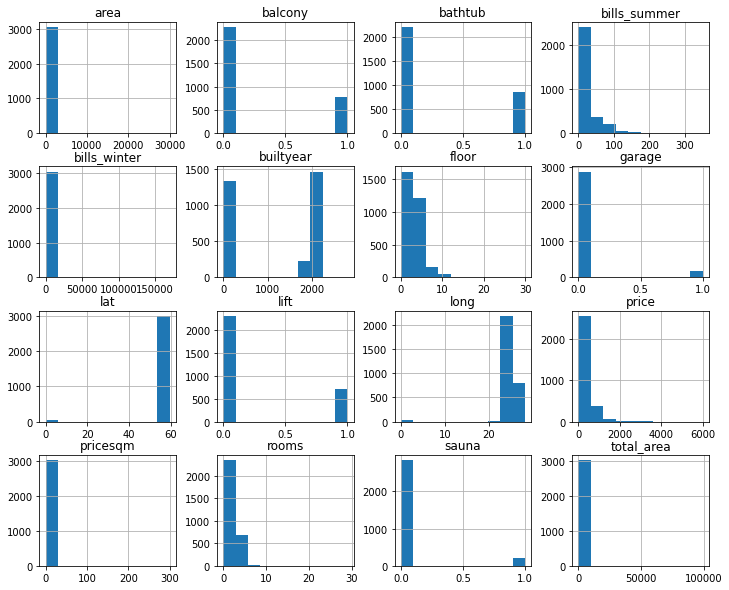

,price,pricesqm,lat,long,rooms,area,total_area,floor,builtyear,bills_summer,...,en_mark_F,en_mark_G,en_mark_H,en_mark_P,parking_0,parking_maja,parking_tasuline,parking_tasuta,kitchen_1,heating_1
2,650.0,13.00,59.430729,24.726902,2.0,50.1,0.0,2.0,2013.0,0.0,...,0,0,0,0,1,0,0,0,1,1
7,700.0,13.50,59.428215,24.778075,3.0,51.7,0.0,1.0,2017.0,75.0,...,0,0,0,0,0,0,1,0,1,1
17,150.0,12.50,59.411850,24.746365,1.0,12.0,0.0,2.0,2012.0,0.0,...,0,0,0,0,0,0,0,1,1,1
30,450.0,9.18,59.459790,24.880667,2.0,49.0,0.0,2.0,1979.0,0.0,...,0,0,0,0,0,0,0,1,1,1
39,760.0,7.83,59.429538,24.727367,3.0,97.0,0.0,3.0,2001.0,0.0,...,0,0,0,0,0,0,0,1,1,1


In [79]:
df_rent_apt = df_rent.copy()
print("Six highest rent before preprocessing")
print(df_rent.price.nlargest(6))
df_rent_apt=df_rent_apt[df_rent_apt.price<9000]
print("Maximum Rent after preprocessing", df_rent_apt.price.max())


plt.rcParams.update({'font.size': 10})
df_rent_apt.hist(figsize = (12,10))
plt.show()


#converting categorical values
df_rent_apt = pd.get_dummies(df_rent_apt)
df_rent_apt.head()


We have got the histogram of 16 plots as we have 16 features with numerical values. 

<Figure size 1080x1080 with 0 Axes>

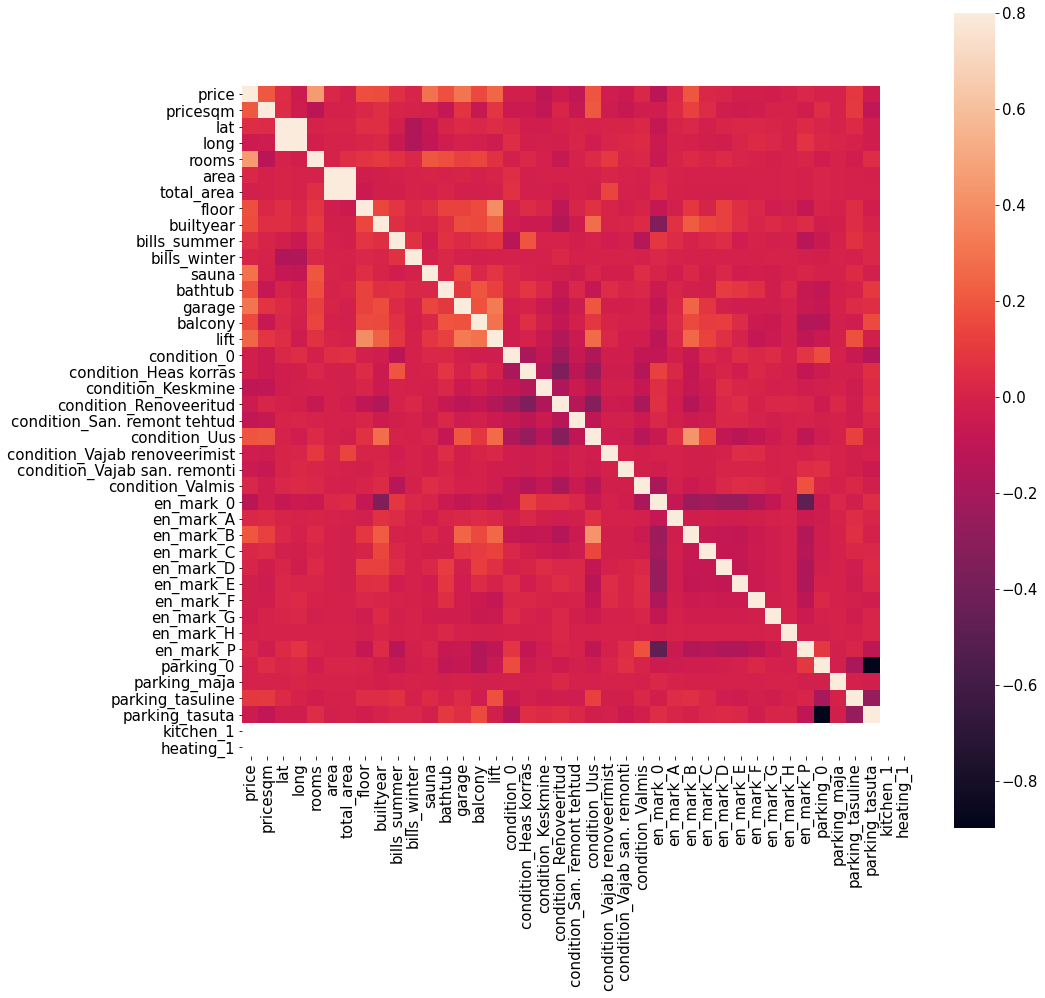

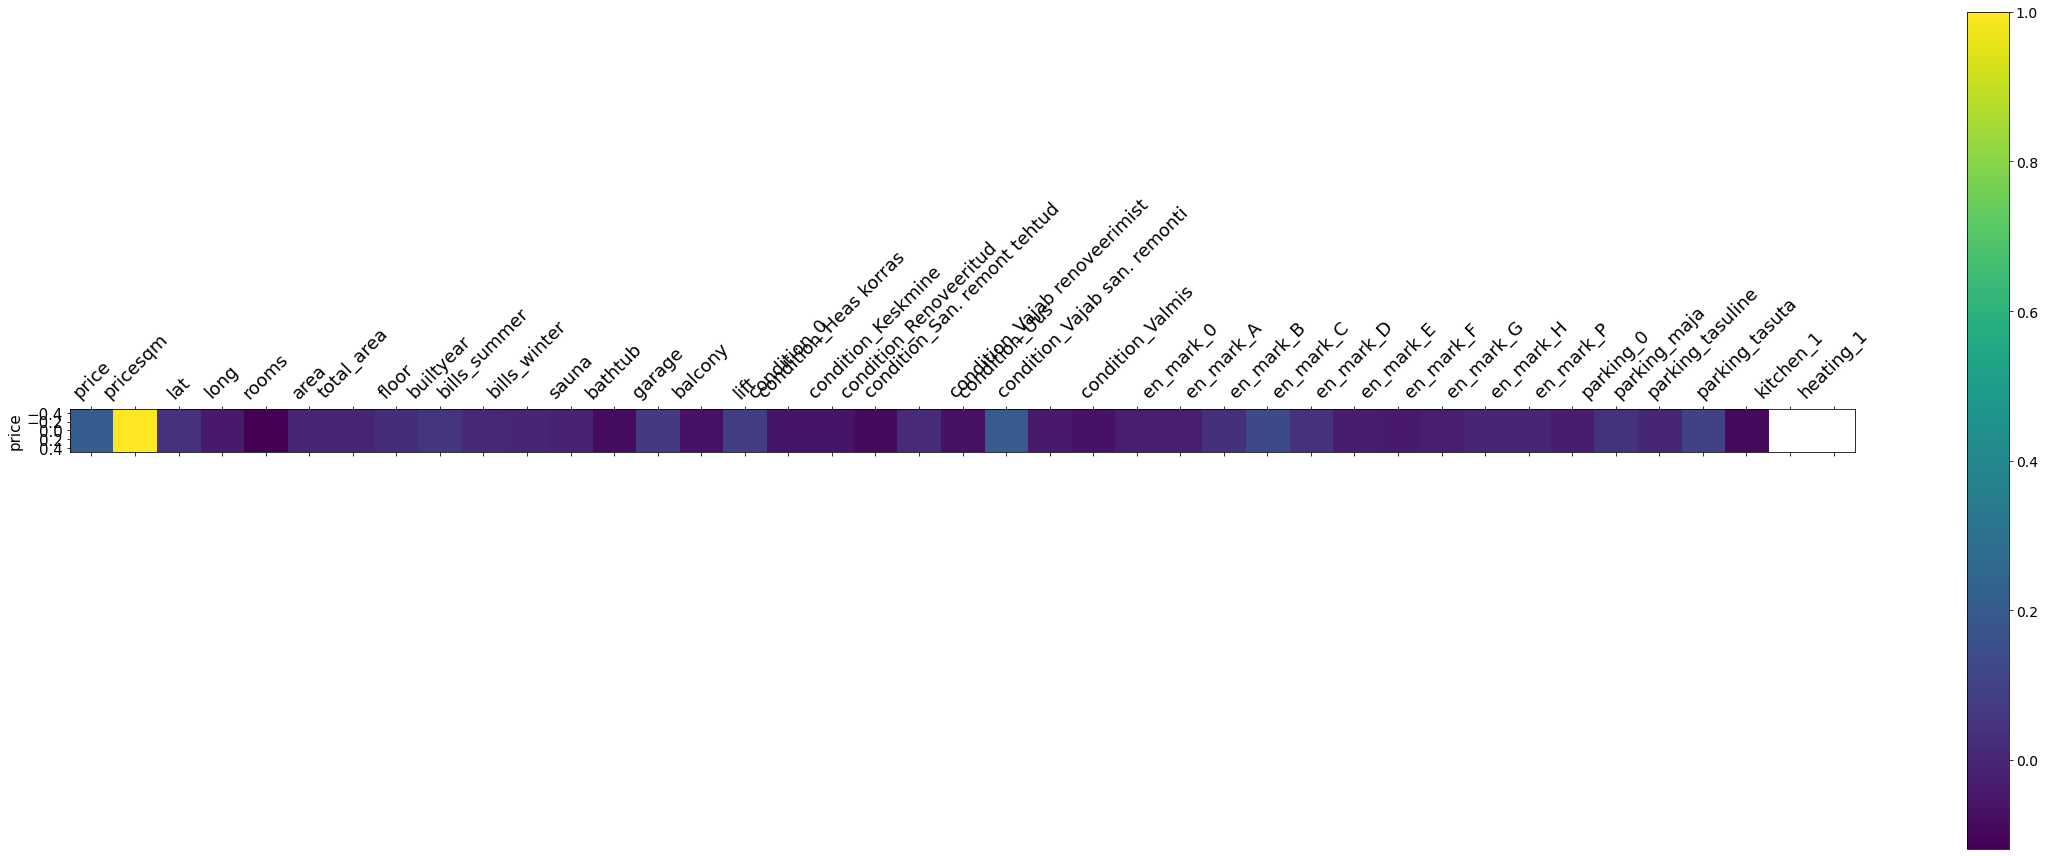

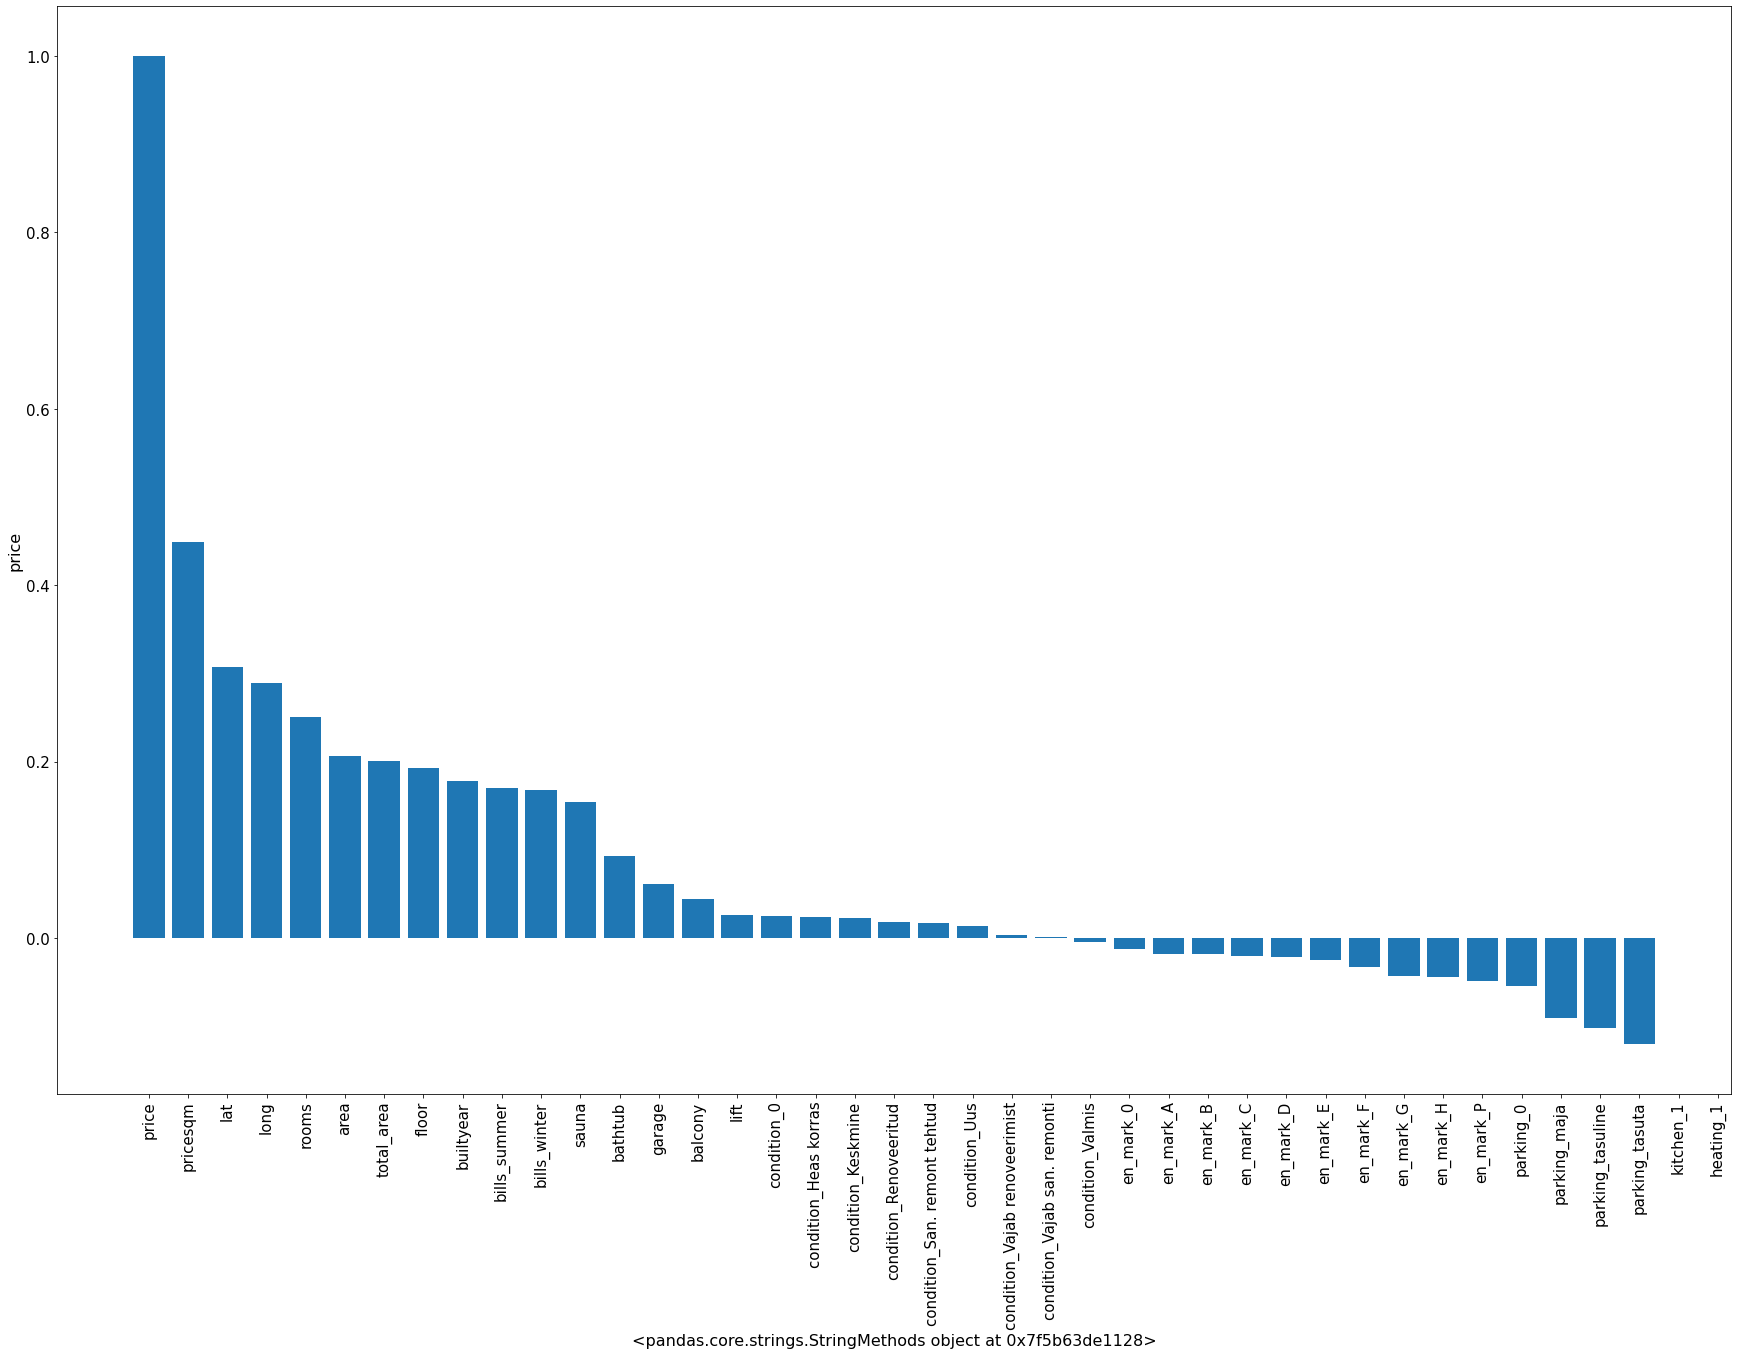

In [77]:
C_mat = df_rent_apt.corr()
fig = plt.figure(figsize = (15,15))
fig = plt.figure(figsize = (15,15))
plt.rcParams.update({'font.size': 15})
sb.heatmap(C_mat, vmax = .8, square = True)
#sb.heatmap(C_mat, annot=False, cmap=plt.cm.Reds)
plt.show()

f = plt.figure(figsize=(40, 15))
plt.matshow(df_rent_apt.corr().iloc[[1]], fignum=f.number, cmap='viridis')
plt.xticks(range(df_rent_apt.shape[1]), df_rent_apt.columns, fontsize=18, rotation=45)
plt.ylabel("price")
cb = plt.colorbar()
cb.ax.tick_params(labelsize=14)
#plt.title('Correlation Matrix', fontsize=16)
plt.show()


plt.figure(figsize=(30, 20))
plt.bar(df_rent_apt.corr()['price'].index,df_rent_apt.corr()['price'].sort_values(ascending=False))
plt.xlabel(df_rent_apt.corr()['price'].index.str, fontsize=16)
plt.ylabel("price", fontsize=16)
plt.xticks(rotation=90)
plt.show()

From the first figure, we can see the relation of the features with each other, and from second and last we can see the relation of all the fetaures with respect to the target variable, price. In the final bar plot, we can see which features have the highest impact on the target value price and which ones has a negative impact on the target value. The final bar plot is very handy to understand which feature has positive and negative impact on the rent of the property. 

In [3]:
#Dataset preparation for training the models
X = df_rent_apt.drop(['price'],axis=1) #dropping target variable
y = df_rent_apt.price

#Train Test split, 80% train data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=56)
print("Shape of the dataset")
print("Training dataset")
print(X_train.shape)
print("Test dataset")
print(X_test.shape)

Shape of the dataset
Training dataset
(2433, 40)
Test dataset
(609, 40)


### Linear Regression
In the following cell, we will implement linear regression. 

In [4]:
reg = LinearRegression().fit(X_train, y_train)
y_pred=reg.predict(X_test)
print("Regression Score")
reg.score(X_train, y_train)

Regression Score


0.4615586631388286

After training we have got an R^2 score of the regression model which does not quite reflect on the model on how well it can predict. Let's plot the predicted values on X axis and the actual rent on Y and we will be able to see the deviation of the prediction from the diagonal line. 

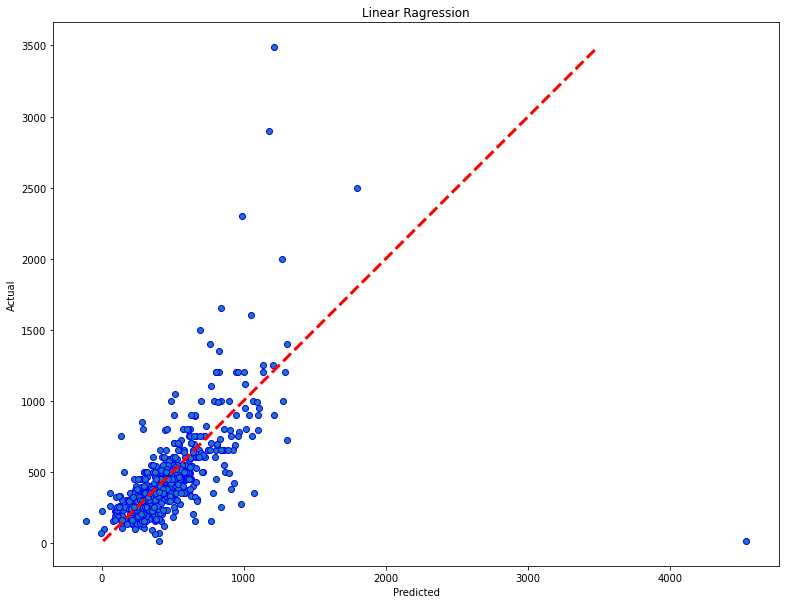

In [5]:
fig, ax = plt.subplots(figsize=(13,10))
ax.scatter(y_pred, y_test, edgecolors=(0, 0, 1))
ax.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=3)
ax.set_title('Linear Ragression')
ax.set_xlabel('Predicted')
ax.set_ylabel('Actual')

plt.show()

As we can see, we have a lot of deviation in the prediction, let's see how the metrics values are for the regression model.

In [6]:
# model evaluation for testing set
from sklearn import metrics 
mae_arr=[]
r2_arr=[]
mse_arr=[]
model_name=[]
mae = metrics.mean_absolute_error(y_test, y_pred)
mse = metrics.mean_squared_error(y_test, y_pred)
r2 = metrics.r2_score(y_test, y_pred)
#acc = metrics.accuracy_score(y_test, y_pred)
mae_arr.append(mae)
r2_arr.append(r2)
mse_arr.append(mse)
model_name.append("Logistic Regression")
print("The model performance for testing set")
print("--------------------------------------")
print('MAE is {}'.format(mae))
print('MSE is {}'.format(mse))
print('R2 score is {}'.format(r2))

The model performance for testing set
--------------------------------------
MAE is 137.50025058716687
MSE is 80280.92566488025
R2 score is 0.21323664054237879


$MAE=\frac{1}{n}\sum_{i=1}^n |y_i-\bar{y_i}|$ <br>
$MSE=\frac{1}{n}\sum_{i=1}^n (y_i-\bar{y_i})^2$ <br>
$R^2=1-\frac{u}{v}, where\ u=\sum_{i=1}^n (y_i-\bar{y_i})^2 \ and \ v=\sum(y_i-\sum_{i=1}^n \frac{y_i}{n})^2$

The mean absolute error is at 137.5 Euro which means, during prediction there might be an average error of 137.5 Euro. This is not acceptable the prediction difference is this much. The Mean Squared Error is also very high, 80280.926 And the R^2 shows how appropriately the model fits to the test data. The higher the R^2, the better the model predicts

### Deep Neural Network
In the following cell we will implement a deep neural network which have 3 hidden layers with 256 neurons each. The final layer has one output as our task in rather regression than classification.. For the hidden layer, relu activation function has been used and for the final layer, a simple linear activation function has been used. For evaluation of the model, we are using mae here as well. 

In [7]:
# Feature Scaling
from sklearn.preprocessing import StandardScaler
#sc = StandardScaler()
#X_train = sc.fit_transform(X_train)
#X_test = sc.transform(X_test)

# Importing the Keras libraries and packages
import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras.callbacks import ModelCheckpoint
NN_model = Sequential()

# The Input Layer :
NN_model.add(Dense(128, kernel_initializer='normal',input_dim = X_train.shape[1], activation='relu'))

# The Hidden Layers :
NN_model.add(Dense(256, kernel_initializer='normal',activation='relu'))
NN_model.add(Dense(256, kernel_initializer='normal',activation='relu'))
NN_model.add(Dense(256, kernel_initializer='normal',activation='relu'))

# The Output Layer :
NN_model.add(Dense(1, kernel_initializer='normal',activation='linear'))

# Compile the network :
NN_model.compile(loss='mean_absolute_error', optimizer='adam', metrics=['mean_absolute_error'])
NN_model.summary()

checkpoint_name = 'Weights-{epoch:03d}--{val_loss:.5f}.hdf5' 
checkpoint = ModelCheckpoint(checkpoint_name, monitor='val_loss', verbose = 1, save_best_only = True, mode ='auto')
callbacks_list = [checkpoint]

NN_model.fit(X_train, y_train, epochs=500, batch_size=16, validation_split = 0.1, callbacks=callbacks_list)


Using TensorFlow backend.
/home/hasan/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:523: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/hasan/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:524: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/hasan/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:525: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/hasan/.local/lib/python3.6/site-packages/tensorflow/python/fra

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 128)               5248      
_________________________________________________________________
dense_2 (Dense)              (None, 256)               33024     
_________________________________________________________________
dense_3 (Dense)              (None, 256)               65792     
_________________________________________________________________
dense_4 (Dense)              (None, 256)               65792     
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 257       
Total params: 170,113
Trainable params: 170,113
Non-trainable params: 0
_________________________________________________________________
Train on 2189 samples, validate on 244 samples
Epoch 1/500
2189/2189 [==============================] - 1s 613us/step - loss: 303.2186 -

2189/2189 [==============================] - 1s 281us/step - loss: 50.9522 - mean_absolute_error: 50.9522 - val_loss: 52.1071 - val_mean_absolute_error: 52.1071

Epoch 00029: val_loss did not improve from 47.32790
Epoch 30/500
2189/2189 [==============================] - 1s 279us/step - loss: 43.7022 - mean_absolute_error: 43.7022 - val_loss: 68.8084 - val_mean_absolute_error: 68.8084

Epoch 00030: val_loss did not improve from 47.32790
Epoch 31/500
2189/2189 [==============================] - 1s 273us/step - loss: 46.3157 - mean_absolute_error: 46.3157 - val_loss: 53.5114 - val_mean_absolute_error: 53.5114

Epoch 00031: val_loss did not improve from 47.32790
Epoch 32/500
2189/2189 [==============================] - 1s 279us/step - loss: 36.8200 - mean_absolute_error: 36.8200 - val_loss: 56.8395 - val_mean_absolute_error: 56.8395

Epoch 00032: val_loss did not improve from 47.32790
Epoch 33/500
2189/2189 [==============================] - 1s 262us/step - loss: 39.6585 - mean_absolute_e

2189/2189 [==============================] - 1s 313us/step - loss: 25.5974 - mean_absolute_error: 25.5974 - val_loss: 50.7515 - val_mean_absolute_error: 50.7515

Epoch 00064: val_loss did not improve from 31.63458
Epoch 65/500
2189/2189 [==============================] - 1s 281us/step - loss: 26.1548 - mean_absolute_error: 26.1548 - val_loss: 37.9795 - val_mean_absolute_error: 37.9795

Epoch 00065: val_loss did not improve from 31.63458
Epoch 66/500
2189/2189 [==============================] - 1s 278us/step - loss: 27.3317 - mean_absolute_error: 27.3317 - val_loss: 36.8994 - val_mean_absolute_error: 36.8994

Epoch 00066: val_loss did not improve from 31.63458
Epoch 67/500
2189/2189 [==============================] - 1s 272us/step - loss: 26.7455 - mean_absolute_error: 26.7455 - val_loss: 32.4339 - val_mean_absolute_error: 32.4339

Epoch 00067: val_loss did not improve from 31.63458
Epoch 68/500
2189/2189 [==============================] - 1s 282us/step - loss: 24.4576 - mean_absolute_e

2189/2189 [==============================] - 1s 258us/step - loss: 22.8546 - mean_absolute_error: 22.8546 - val_loss: 32.8249 - val_mean_absolute_error: 32.8249

Epoch 00099: val_loss did not improve from 26.66869
Epoch 100/500
2189/2189 [==============================] - 1s 259us/step - loss: 20.5564 - mean_absolute_error: 20.5564 - val_loss: 26.4164 - val_mean_absolute_error: 26.4164

Epoch 00100: val_loss improved from 26.66869 to 26.41639, saving model to Weights-100--26.41639.hdf5
Epoch 101/500
2189/2189 [==============================] - 1s 266us/step - loss: 22.2145 - mean_absolute_error: 22.2145 - val_loss: 38.4872 - val_mean_absolute_error: 38.4872

Epoch 00101: val_loss did not improve from 26.41639
Epoch 102/500
2189/2189 [==============================] - 1s 280us/step - loss: 19.9553 - mean_absolute_error: 19.9553 - val_loss: 29.1051 - val_mean_absolute_error: 29.1051

Epoch 00102: val_loss did not improve from 26.41639
Epoch 103/500
2189/2189 [============================

2189/2189 [==============================] - 1s 262us/step - loss: 19.6041 - mean_absolute_error: 19.6041 - val_loss: 26.2518 - val_mean_absolute_error: 26.2518

Epoch 00134: val_loss did not improve from 23.38403
Epoch 135/500
2189/2189 [==============================] - 1s 281us/step - loss: 20.4704 - mean_absolute_error: 20.4704 - val_loss: 28.2183 - val_mean_absolute_error: 28.2183

Epoch 00135: val_loss did not improve from 23.38403
Epoch 136/500
2189/2189 [==============================] - 1s 276us/step - loss: 19.6149 - mean_absolute_error: 19.6149 - val_loss: 29.1715 - val_mean_absolute_error: 29.1715

Epoch 00136: val_loss did not improve from 23.38403
Epoch 137/500
2189/2189 [==============================] - 1s 277us/step - loss: 18.2189 - mean_absolute_error: 18.2189 - val_loss: 38.5745 - val_mean_absolute_error: 38.5745

Epoch 00137: val_loss did not improve from 23.38403
Epoch 138/500
2189/2189 [==============================] - 1s 272us/step - loss: 23.6237 - mean_absolu

2189/2189 [==============================] - 1s 269us/step - loss: 24.3001 - mean_absolute_error: 24.3001 - val_loss: 29.6118 - val_mean_absolute_error: 29.6118

Epoch 00170: val_loss did not improve from 22.61895
Epoch 171/500
2189/2189 [==============================] - 1s 279us/step - loss: 18.9674 - mean_absolute_error: 18.9674 - val_loss: 24.2941 - val_mean_absolute_error: 24.2941

Epoch 00171: val_loss did not improve from 22.61895
Epoch 172/500
2189/2189 [==============================] - 1s 261us/step - loss: 22.5814 - mean_absolute_error: 22.5814 - val_loss: 38.9225 - val_mean_absolute_error: 38.9225

Epoch 00172: val_loss did not improve from 22.61895
Epoch 173/500
2189/2189 [==============================] - 1s 275us/step - loss: 18.1876 - mean_absolute_error: 18.1876 - val_loss: 23.8622 - val_mean_absolute_error: 23.8622

Epoch 00173: val_loss did not improve from 22.61895
Epoch 174/500
2189/2189 [==============================] - 1s 272us/step - loss: 19.8082 - mean_absolu

2189/2189 [==============================] - 1s 277us/step - loss: 17.3751 - mean_absolute_error: 17.3751 - val_loss: 23.9017 - val_mean_absolute_error: 23.9017

Epoch 00206: val_loss did not improve from 21.77597
Epoch 207/500
2189/2189 [==============================] - 1s 268us/step - loss: 17.0258 - mean_absolute_error: 17.0258 - val_loss: 32.3915 - val_mean_absolute_error: 32.3915

Epoch 00207: val_loss did not improve from 21.77597
Epoch 208/500
2189/2189 [==============================] - 1s 269us/step - loss: 16.7160 - mean_absolute_error: 16.7160 - val_loss: 23.6051 - val_mean_absolute_error: 23.6051

Epoch 00208: val_loss did not improve from 21.77597
Epoch 209/500
2189/2189 [==============================] - 1s 265us/step - loss: 16.9559 - mean_absolute_error: 16.9559 - val_loss: 32.2328 - val_mean_absolute_error: 32.2328

Epoch 00209: val_loss did not improve from 21.77597
Epoch 210/500
2189/2189 [==============================] - 1s 262us/step - loss: 16.8618 - mean_absolu

2189/2189 [==============================] - 1s 267us/step - loss: 15.8388 - mean_absolute_error: 15.8388 - val_loss: 29.1356 - val_mean_absolute_error: 29.1356

Epoch 00242: val_loss did not improve from 21.77597
Epoch 243/500
2189/2189 [==============================] - 1s 264us/step - loss: 17.2663 - mean_absolute_error: 17.2663 - val_loss: 28.9845 - val_mean_absolute_error: 28.9845

Epoch 00243: val_loss did not improve from 21.77597
Epoch 244/500
2189/2189 [==============================] - 1s 260us/step - loss: 18.2798 - mean_absolute_error: 18.2798 - val_loss: 36.3021 - val_mean_absolute_error: 36.3021

Epoch 00244: val_loss did not improve from 21.77597
Epoch 245/500
2189/2189 [==============================] - 1s 280us/step - loss: 19.8789 - mean_absolute_error: 19.8789 - val_loss: 40.3864 - val_mean_absolute_error: 40.3864

Epoch 00245: val_loss did not improve from 21.77597
Epoch 246/500
2189/2189 [==============================] - 1s 260us/step - loss: 19.2821 - mean_absolu

2189/2189 [==============================] - 1s 301us/step - loss: 19.3136 - mean_absolute_error: 19.3136 - val_loss: 26.7301 - val_mean_absolute_error: 26.7301

Epoch 00278: val_loss did not improve from 21.66333
Epoch 279/500
2189/2189 [==============================] - 1s 360us/step - loss: 17.0714 - mean_absolute_error: 17.0714 - val_loss: 24.9284 - val_mean_absolute_error: 24.9284

Epoch 00279: val_loss did not improve from 21.66333
Epoch 280/500
2189/2189 [==============================] - 1s 301us/step - loss: 16.0595 - mean_absolute_error: 16.0595 - val_loss: 30.8068 - val_mean_absolute_error: 30.8068

Epoch 00280: val_loss did not improve from 21.66333
Epoch 281/500
2189/2189 [==============================] - 1s 278us/step - loss: 16.9641 - mean_absolute_error: 16.9641 - val_loss: 24.5642 - val_mean_absolute_error: 24.5642

Epoch 00281: val_loss did not improve from 21.66333
Epoch 282/500
2189/2189 [==============================] - 1s 286us/step - loss: 17.4330 - mean_absolu

2189/2189 [==============================] - 1s 275us/step - loss: 16.1909 - mean_absolute_error: 16.1909 - val_loss: 26.1496 - val_mean_absolute_error: 26.1496

Epoch 00314: val_loss did not improve from 21.66333
Epoch 315/500
2189/2189 [==============================] - 1s 276us/step - loss: 14.1376 - mean_absolute_error: 14.1376 - val_loss: 20.1101 - val_mean_absolute_error: 20.1101

Epoch 00315: val_loss improved from 21.66333 to 20.11006, saving model to Weights-315--20.11006.hdf5
Epoch 316/500
2189/2189 [==============================] - 1s 278us/step - loss: 15.9710 - mean_absolute_error: 15.9710 - val_loss: 22.4864 - val_mean_absolute_error: 22.4864

Epoch 00316: val_loss did not improve from 20.11006
Epoch 317/500
2189/2189 [==============================] - 1s 263us/step - loss: 13.9155 - mean_absolute_error: 13.9155 - val_loss: 28.9772 - val_mean_absolute_error: 28.9772

Epoch 00317: val_loss did not improve from 20.11006
Epoch 318/500
2189/2189 [============================

2189/2189 [==============================] - 1s 266us/step - loss: 15.8966 - mean_absolute_error: 15.8966 - val_loss: 23.5402 - val_mean_absolute_error: 23.5402

Epoch 00350: val_loss did not improve from 20.11006
Epoch 351/500
2189/2189 [==============================] - 1s 273us/step - loss: 14.3611 - mean_absolute_error: 14.3611 - val_loss: 21.5777 - val_mean_absolute_error: 21.5777

Epoch 00351: val_loss did not improve from 20.11006
Epoch 352/500
2189/2189 [==============================] - 1s 257us/step - loss: 17.0387 - mean_absolute_error: 17.0387 - val_loss: 41.9142 - val_mean_absolute_error: 41.9142

Epoch 00352: val_loss did not improve from 20.11006
Epoch 353/500
2189/2189 [==============================] - 1s 283us/step - loss: 17.6089 - mean_absolute_error: 17.6089 - val_loss: 22.2331 - val_mean_absolute_error: 22.2331

Epoch 00353: val_loss did not improve from 20.11006
Epoch 354/500
2189/2189 [==============================] - 1s 266us/step - loss: 14.2404 - mean_absolu

2189/2189 [==============================] - 1s 273us/step - loss: 14.2843 - mean_absolute_error: 14.2843 - val_loss: 26.3771 - val_mean_absolute_error: 26.3771

Epoch 00386: val_loss did not improve from 20.11006
Epoch 387/500
2189/2189 [==============================] - 1s 263us/step - loss: 14.2208 - mean_absolute_error: 14.2208 - val_loss: 22.9569 - val_mean_absolute_error: 22.9569

Epoch 00387: val_loss did not improve from 20.11006
Epoch 388/500
2189/2189 [==============================] - 1s 273us/step - loss: 13.4307 - mean_absolute_error: 13.4307 - val_loss: 21.5249 - val_mean_absolute_error: 21.5249

Epoch 00388: val_loss did not improve from 20.11006
Epoch 389/500
2189/2189 [==============================] - 1s 271us/step - loss: 15.0893 - mean_absolute_error: 15.0893 - val_loss: 27.7540 - val_mean_absolute_error: 27.7540

Epoch 00389: val_loss did not improve from 20.11006
Epoch 390/500
2189/2189 [==============================] - 1s 278us/step - loss: 14.1628 - mean_absolu

2189/2189 [==============================] - 1s 280us/step - loss: 13.2629 - mean_absolute_error: 13.2629 - val_loss: 22.2425 - val_mean_absolute_error: 22.2425

Epoch 00422: val_loss did not improve from 20.11006
Epoch 423/500
2189/2189 [==============================] - 1s 271us/step - loss: 13.3920 - mean_absolute_error: 13.3920 - val_loss: 42.5668 - val_mean_absolute_error: 42.5668

Epoch 00423: val_loss did not improve from 20.11006
Epoch 424/500
2189/2189 [==============================] - 1s 289us/step - loss: 17.2103 - mean_absolute_error: 17.2103 - val_loss: 23.2611 - val_mean_absolute_error: 23.2611

Epoch 00424: val_loss did not improve from 20.11006
Epoch 425/500
2189/2189 [==============================] - 1s 351us/step - loss: 13.7486 - mean_absolute_error: 13.7486 - val_loss: 22.8512 - val_mean_absolute_error: 22.8512

Epoch 00425: val_loss did not improve from 20.11006
Epoch 426/500
2189/2189 [==============================] - 1s 308us/step - loss: 14.1920 - mean_absolu

2189/2189 [==============================] - 1s 275us/step - loss: 12.7654 - mean_absolute_error: 12.7654 - val_loss: 20.1820 - val_mean_absolute_error: 20.1820

Epoch 00458: val_loss did not improve from 20.11006
Epoch 459/500
2189/2189 [==============================] - 1s 263us/step - loss: 13.4603 - mean_absolute_error: 13.4603 - val_loss: 22.8266 - val_mean_absolute_error: 22.8266

Epoch 00459: val_loss did not improve from 20.11006
Epoch 460/500
2189/2189 [==============================] - 1s 279us/step - loss: 12.6804 - mean_absolute_error: 12.6804 - val_loss: 25.3049 - val_mean_absolute_error: 25.3049

Epoch 00460: val_loss did not improve from 20.11006
Epoch 461/500
2189/2189 [==============================] - 1s 366us/step - loss: 14.7596 - mean_absolute_error: 14.7596 - val_loss: 27.6411 - val_mean_absolute_error: 27.6411

Epoch 00461: val_loss did not improve from 20.11006
Epoch 462/500
2189/2189 [==============================] - 1s 317us/step - loss: 13.0539 - mean_absolu

2189/2189 [==============================] - 1s 286us/step - loss: 11.9924 - mean_absolute_error: 11.9924 - val_loss: 20.8240 - val_mean_absolute_error: 20.8240

Epoch 00494: val_loss did not improve from 19.71726
Epoch 495/500
2189/2189 [==============================] - 1s 288us/step - loss: 14.1468 - mean_absolute_error: 14.1468 - val_loss: 22.5458 - val_mean_absolute_error: 22.5458

Epoch 00495: val_loss did not improve from 19.71726
Epoch 496/500
2189/2189 [==============================] - 1s 280us/step - loss: 13.7925 - mean_absolute_error: 13.7925 - val_loss: 23.7194 - val_mean_absolute_error: 23.7194

Epoch 00496: val_loss did not improve from 19.71726
Epoch 497/500
2189/2189 [==============================] - 1s 278us/step - loss: 14.3049 - mean_absolute_error: 14.3049 - val_loss: 22.1385 - val_mean_absolute_error: 22.1385

Epoch 00497: val_loss did not improve from 19.71726
Epoch 498/500
2189/2189 [==============================] - 1s 267us/step - loss: 14.4994 - mean_absolu

After training the model for 500 epochs, now we take a look at the training and test loss value. Note to mention, we have saved the models as .hd5 keras models. Once the previous is being run, the models will be saved automatically, just pick latest one as that has the lowest MAE for test set. 

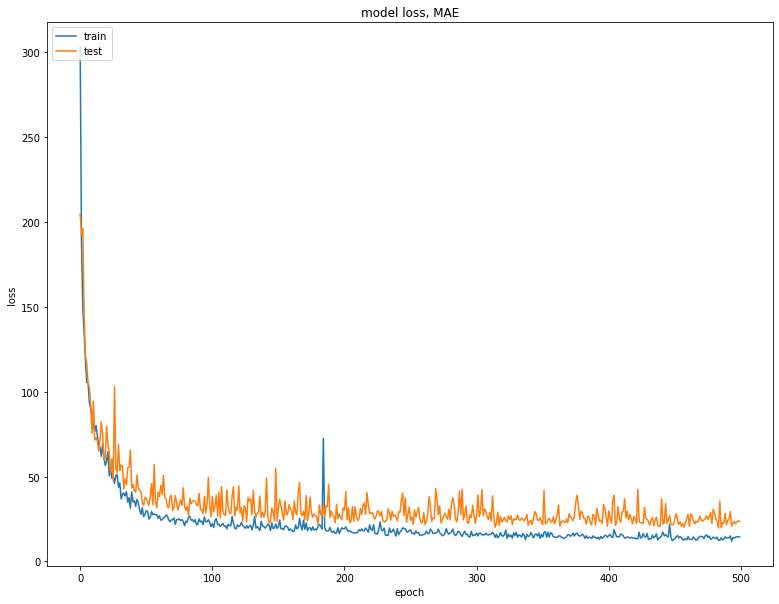

Minimum test loss for this model is: 
19.717261455098136


In [9]:
wights_file = 'Weights-484--19.71726.hdf5' # choose the best checkpoint 
NN_model.load_weights(wights_file) # load it
NN_model.compile(loss='mean_absolute_error', optimizer='adam', metrics=['mean_absolute_error'])
predictions = NN_model.predict(X_test)
mae_arr.append(min(NN_model.history.history['val_loss']))
model_name.append("Neural Network")


fig, ax = plt.subplots(figsize=(13,10))
plt.plot(NN_model.history.history['loss'])
plt.plot(NN_model.history.history['val_loss'])
plt.title('model loss, MAE')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
print("Minimum test loss for this model is: ")
print(min(NN_model.history.history['val_loss']))

As we can see that the loss values are converging and the MAE in validation set for this deep neural network is 19.71 Euro which is quite good. A deviation of around 19 euro during rent prediction is not as high as the linear regression. 

The model performance for testing set
--------------------------------------
MAE is 19.43616417172703
MSE is 11754.404880500171
R2 score is 0.8848053258527264


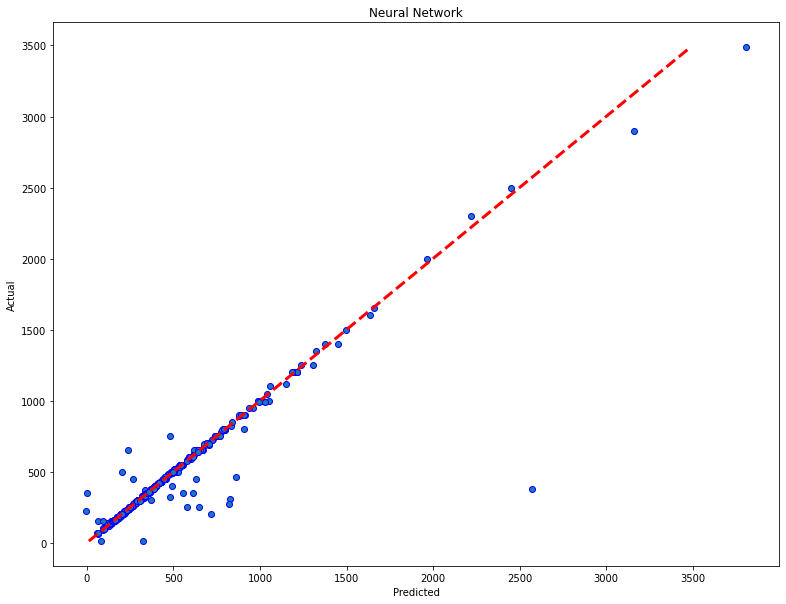

In [10]:
pred=NN_model.predict(X_test)

mae = metrics.mean_absolute_error(y_test, pred)
mse = metrics.mean_squared_error(y_test, pred)
r2 = metrics.r2_score(y_test, pred)
r2_arr.append(r2)
mse_arr.append(mse)

print("The model performance for testing set")
print("--------------------------------------")
print('MAE is {}'.format(mae))
print('MSE is {}'.format(mse))
print('R2 score is {}'.format(r2))
fig, ax = plt.subplots(figsize=(13,10))
ax.scatter(pred, y_test, edgecolors=(0, 0, 1))
ax.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=3)
ax.set_title('Neural Network')
ax.set_xlabel('Predicted')
ax.set_ylabel('Actual')
plt.show()

As expected, the MAE on test data is 19.44. The R^2 is around 0.8848 which can be visible in the diagram. All the points are overlapping on the diagonal line except a few. 

### Random Forest Regressor

The model performance for testing set
--------------------------------------
MAE is 30.705346469622327
MSE is 21033.698552894082
R2 score is 0.7938670587285818


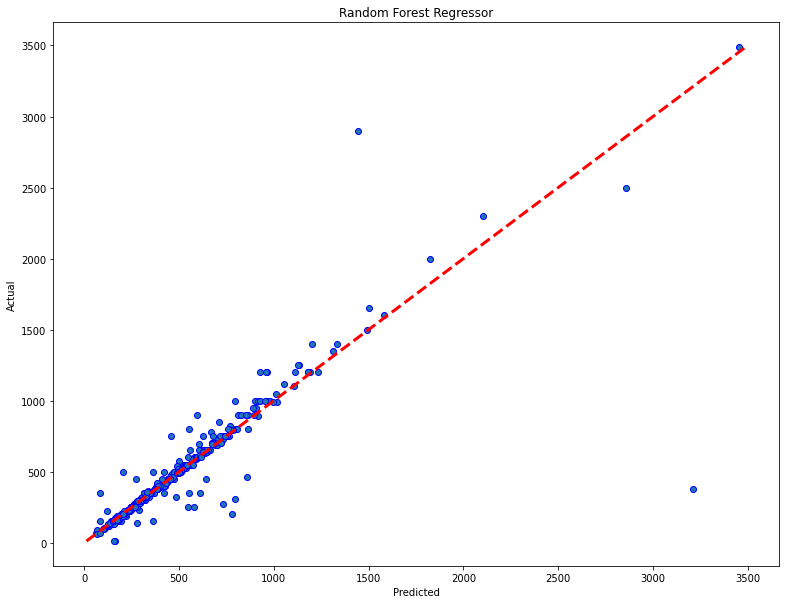

In [13]:
model = RandomForestRegressor()
model.fit(X_train,y_train)
predicted_prices = model.predict(X_test)

mae = metrics.mean_absolute_error(y_test, predicted_prices)
mse = metrics.mean_squared_error(y_test, predicted_prices)
r2 = metrics.r2_score(y_test, predicted_prices)
print("The model performance for testing set")
print("--------------------------------------")
print('MAE is {}'.format(mae))
print('MSE is {}'.format(mse))
print('R2 score is {}'.format(r2))

mae_arr.append(mae)
model_name.append("Random Forest Regressor")
r2_arr.append(r2)
mse_arr.append(mse)

fig, ax = plt.subplots(figsize=(13,10))

ax.scatter(predicted_prices, y_test, edgecolors=(0, 0, 1))
ax.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=3)
ax.set_title('Random Forest Regressor')
ax.set_xlabel('Predicted')
ax.set_ylabel('Actual')
plt.show()

As the MAE and MSE suggests, this model does not perform as good as deep neural network. Also, the model does not fit as good as well. 

The model performance for testing set
--------------------------------------
MAE is 34.19175324964601
MSE is 14638.919693699583
R2 score is 0.8565367110349126


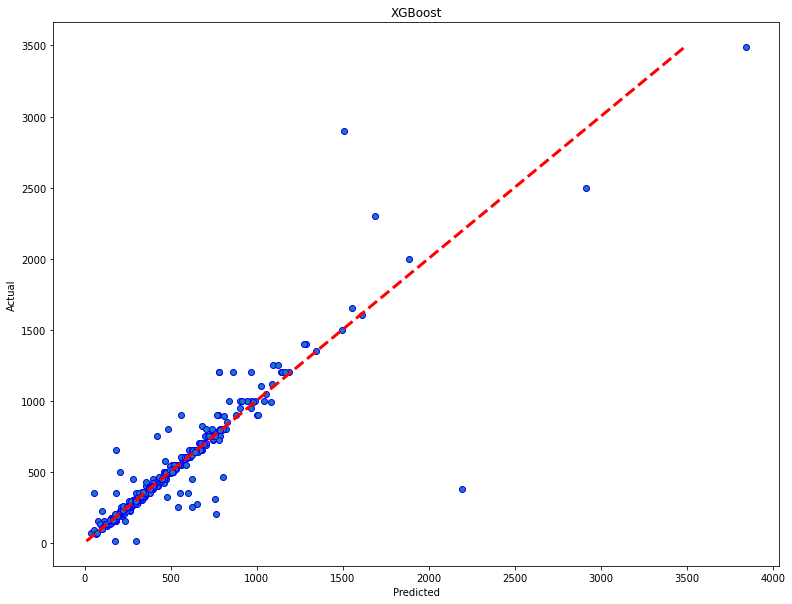

In [20]:
XGBModel = XGBRegressor()
XGBModel.fit(X_train,y_train , verbose=False)

XGBpredictions = XGBModel.predict(X_test)
mae = metrics.mean_absolute_error(y_test, XGBpredictions)
mse = metrics.mean_squared_error(y_test, XGBpredictions)
r2 = metrics.r2_score(y_test, XGBpredictions)
print("The model performance for testing set")
print("--------------------------------------")
print('MAE is {}'.format(mae))
print('MSE is {}'.format(mse))
print('R2 score is {}'.format(r2))

mae_arr.append(mae)
model_name.append("XGBoost")
r2_arr.append(r2)
mse_arr.append(mse)
fig, ax = plt.subplots(figsize=(13,10))

ax.scatter(XGBpredictions, y_test, edgecolors=(0, 0, 1))
ax.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=3)
ax.set_title('XGBoost')
ax.set_xlabel('Predicted')
ax.set_ylabel('Actual')
plt.show()

XGBoost seems a bit better compared to Random Forest Regressor and basic linear regression not coudl not beat deep neural network. 

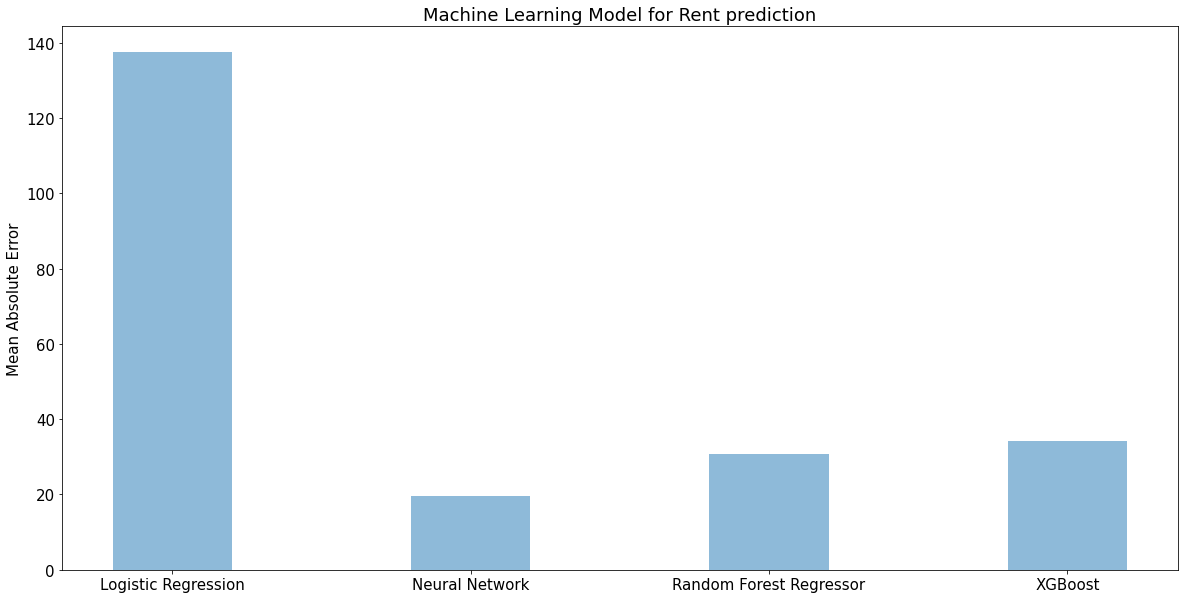

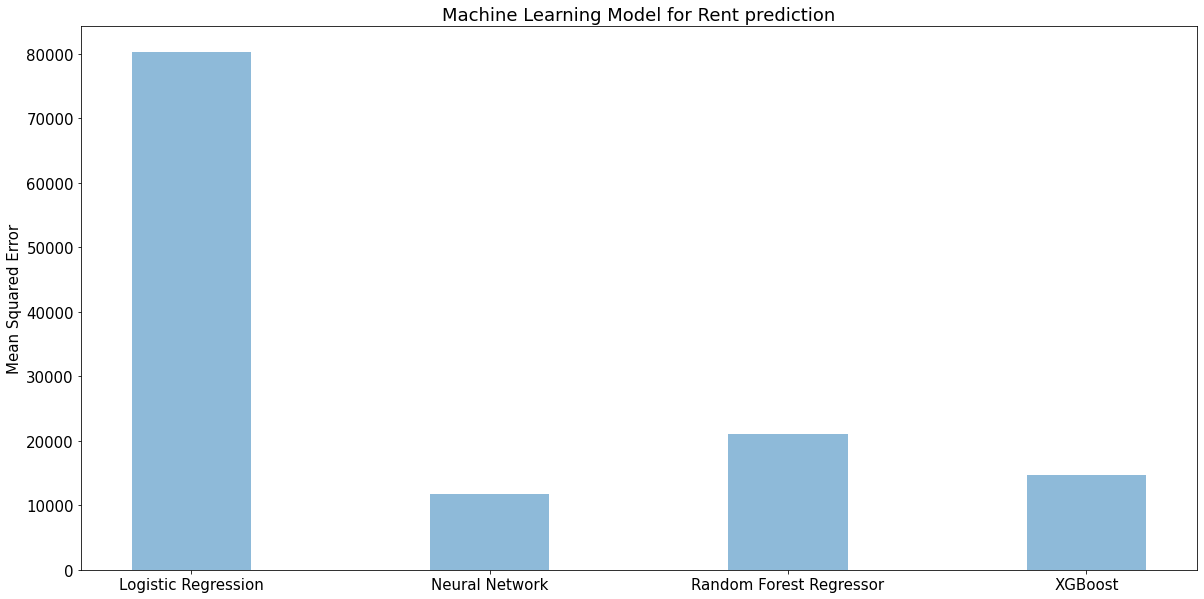

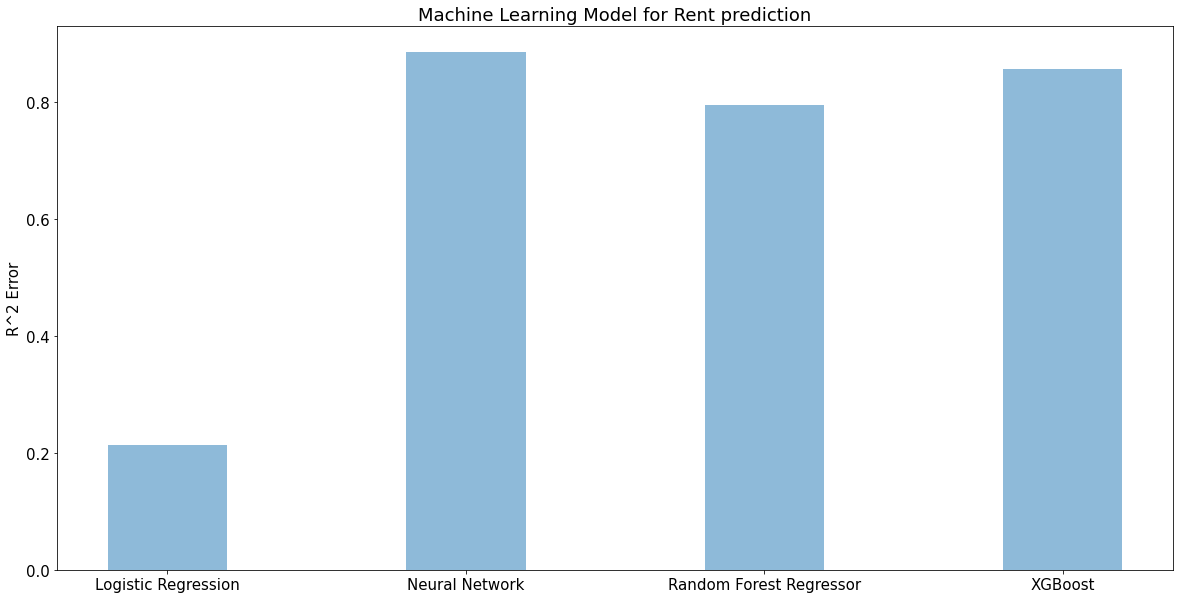

In [89]:
plt.figure(figsize=(20,10))
plt.rcParams.update({'font.size': 15})
plt.bar(model_name, mae_arr, align='center', alpha=0.5, width=0.4)
#plt.xticks(model_name, mae_arr)
plt.ylabel('Mean Absolute Error')
plt.title('Machine Learning Model for Rent prediction')
plt.show()


plt.figure(figsize=(20,10))
plt.bar(model_name, mse_arr, align='center', alpha=0.5, width=0.4)
#plt.xticks(model_name, mae_arr)
plt.ylabel('Mean Squared Error')
plt.title('Machine Learning Model for Rent prediction')
plt.show()


plt.figure(figsize=(20,10))
plt.bar(model_name, r2_arr, align='center', alpha=0.5, width=0.4)
#plt.xticks(model_name, mae_arr)
plt.ylabel('R^2 Error')
plt.title('Machine Learning Model for Rent prediction')
plt.show()



### In conclusion, we can say that deep neural network performs better than other three models in predicting rent of the apartments.